In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [12]:
data_excel = pd.read_csv("data/Base14.csv")
dataframe_data = pd.DataFrame(data_excel)
print(dataframe_data)

             x         y  label
0     3.381569 -3.421758      2
1     5.159139  6.815702      1
2     7.250949  8.434215      1
3     6.144624  3.325288      1
4    -2.600138 -0.044972      0
...        ...       ...    ...
1995  3.533525 -9.481305      2
1996  3.034379 -5.980947      2
1997 -4.094759  2.508122      0
1998  4.490083 -3.492859      2
1999  6.810115 -7.448688      2

[2000 rows x 3 columns]


<Figure size 800x500 with 0 Axes>

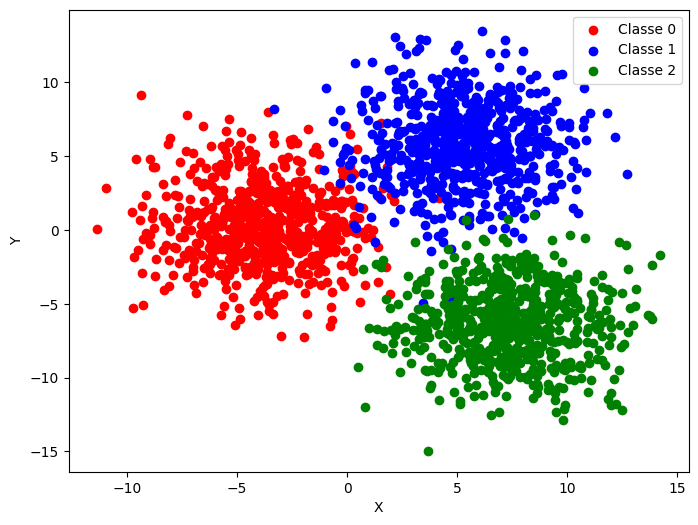

In [13]:
plt.figure(figsize=(8,5))
label_colors = {0: 'red', 1: 'blue', 2: 'green'}

# Create the scatter plot
plt.figure(figsize=(8, 6))
for label, color in label_colors.items():
    subset = dataframe_data[dataframe_data['label'] == label]
    plt.scatter(subset['x'], subset['y'], c=color, label=f'Classe {label}')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

In [14]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(dataframe_data)
centro = kmeans.cluster_centers_
X = kmeans.labels_

c:\Program Files\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


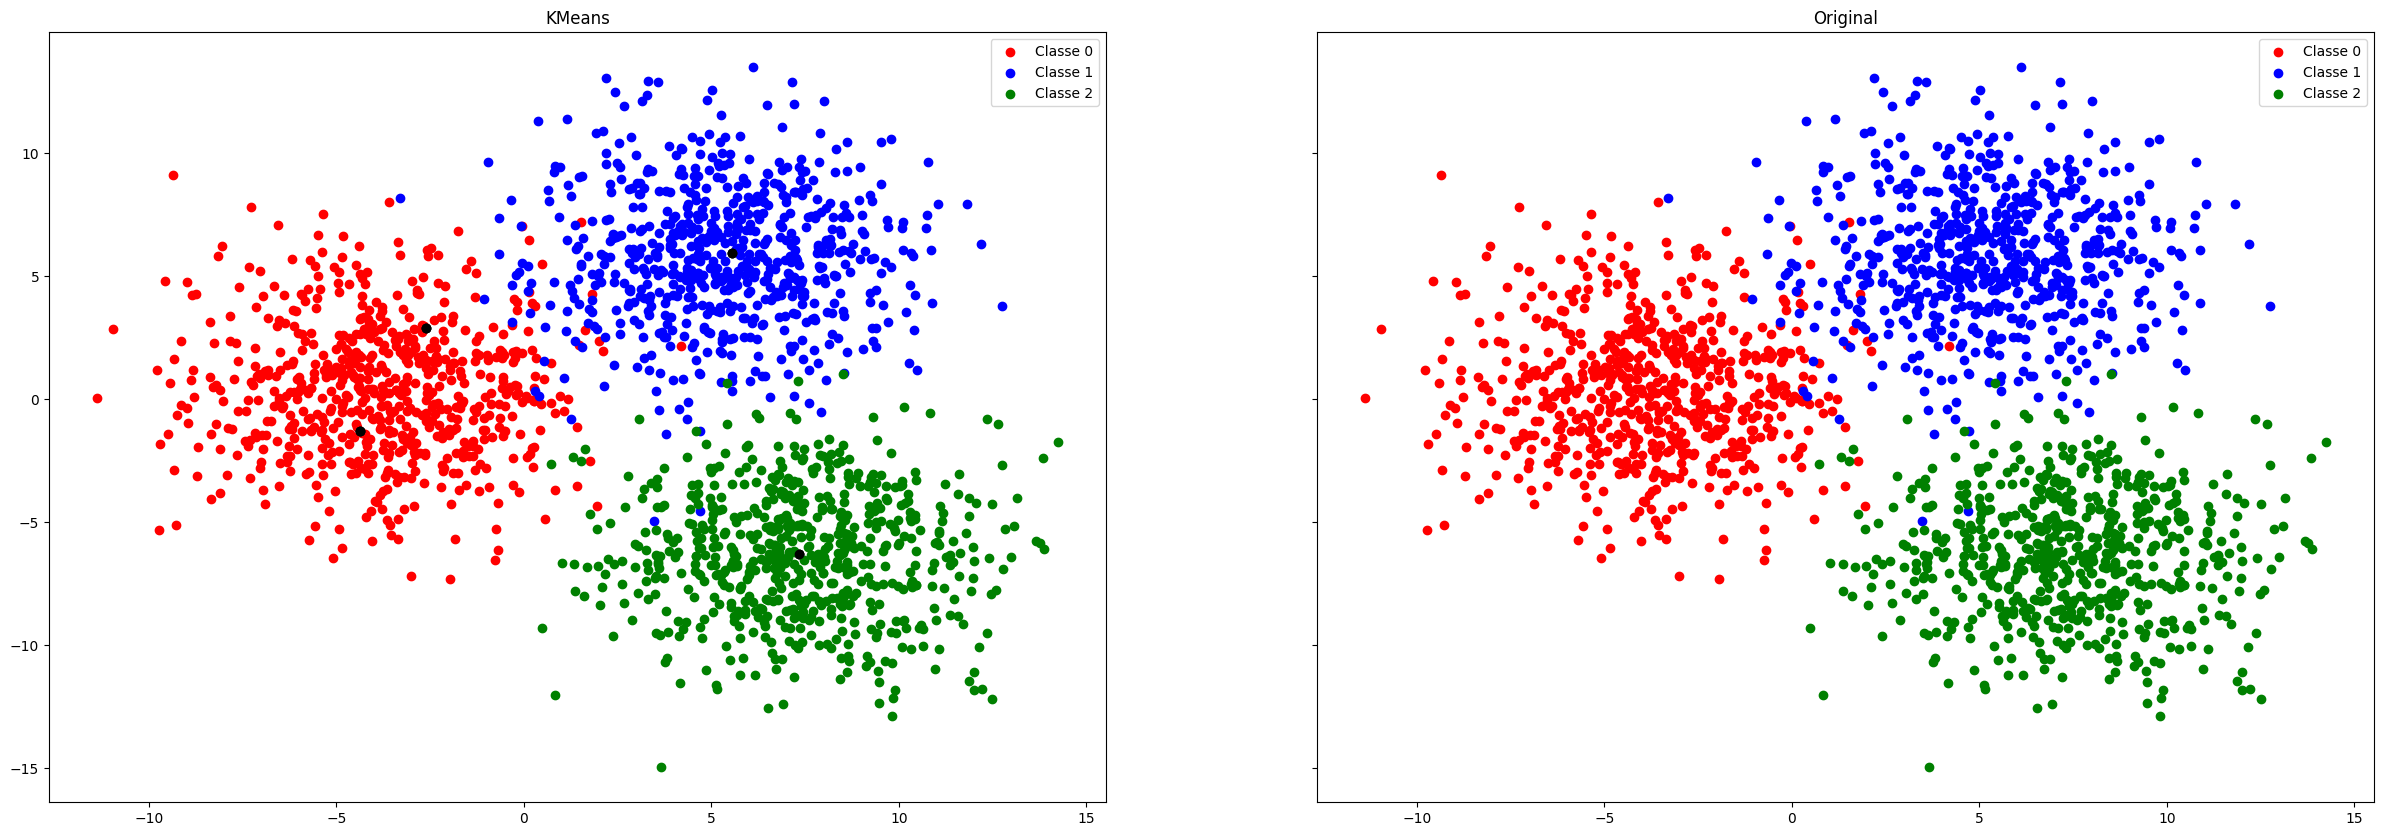

In [15]:
f,(ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(30,10),label='Classe')
ax1.set_title("KMeans")
for label, color in label_colors.items():
    subset = dataframe_data[dataframe_data['label'] == label]
    ax1.scatter(subset['x'], subset['y'], c=color, label=f'Classe {label}')
    ax1.scatter(centro[:,0],centro[:,1],color='black')
ax1.legend()
ax2.set_title("Original")
for label, color in label_colors.items():
    subset = dataframe_data[dataframe_data['label'] == label]
    ax2.scatter(subset['x'], subset['y'], c=color, label=f'Classe {label}')

# Add labels and legend
ax2.legend()


In [16]:
db = DBSCAN(eps=0.7, min_samples=10)
db.fit(dataframe_data)
X = db.labels_

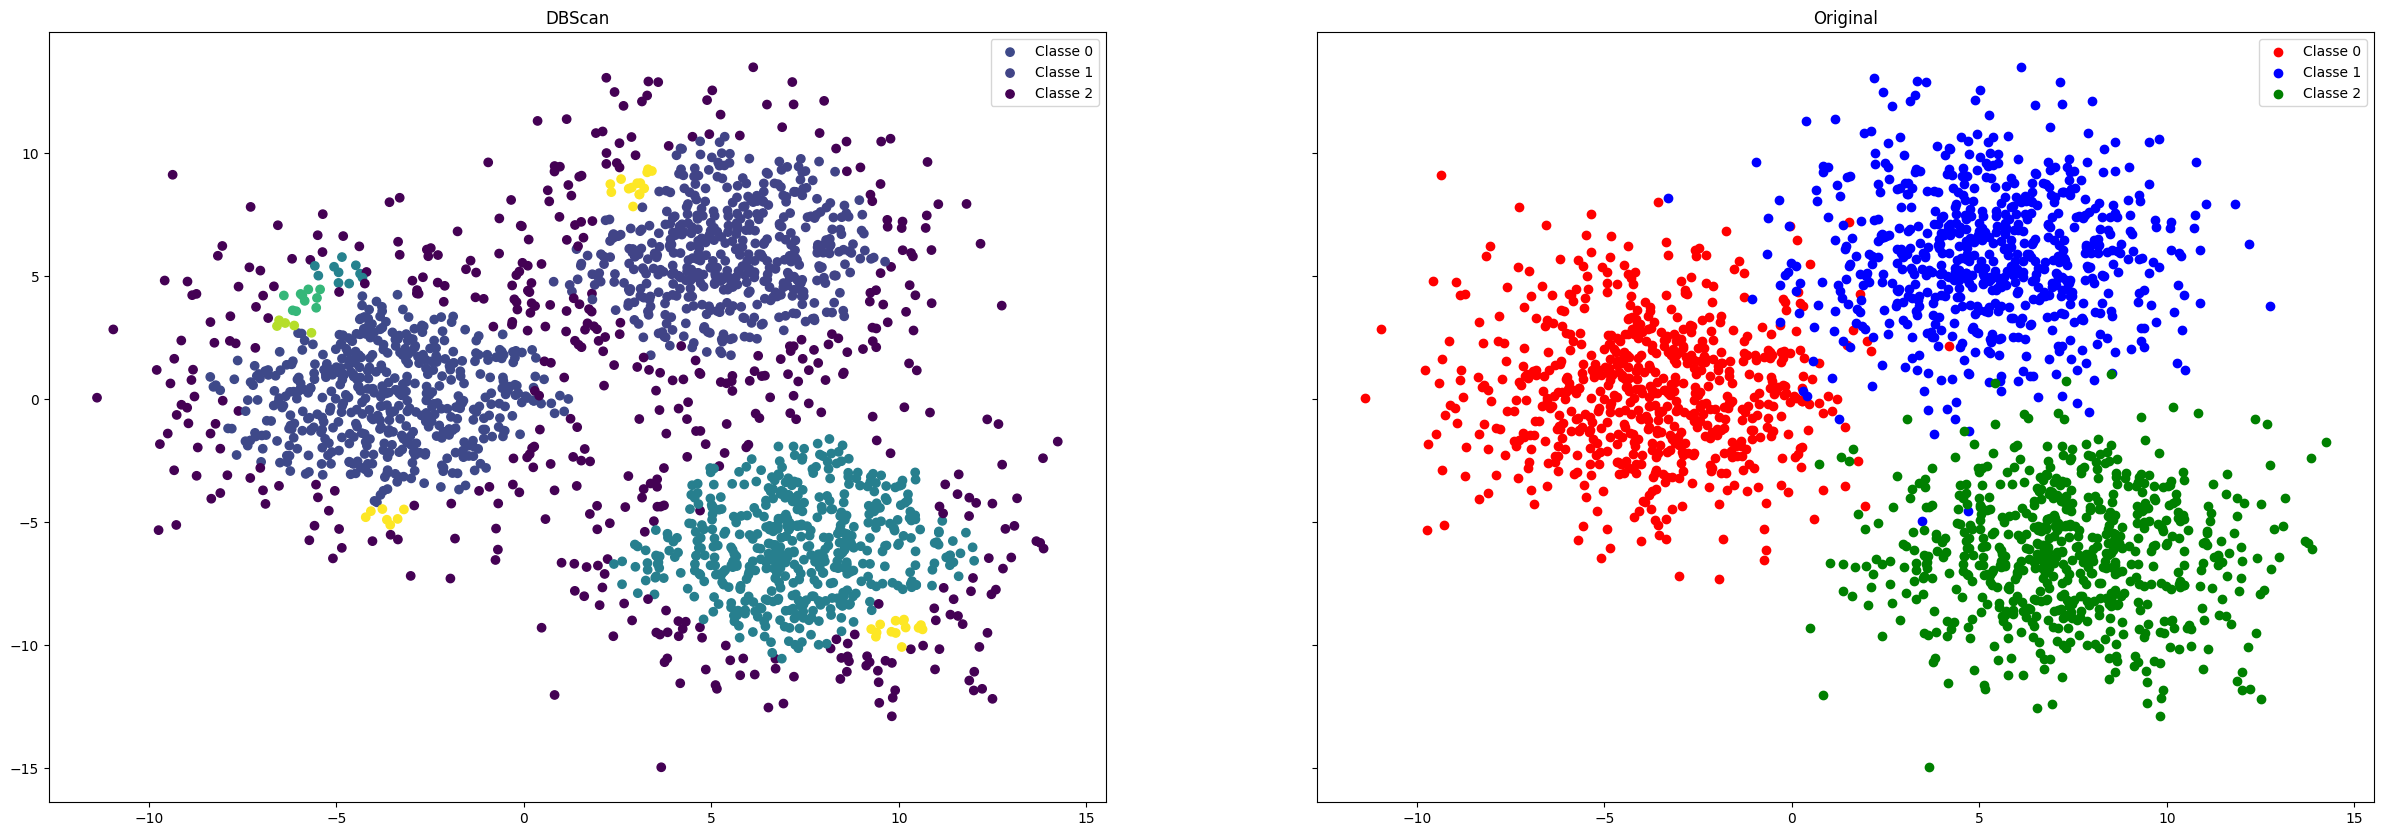

In [17]:
f,(ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(30,10),label='Classe')
ax1.set_title("DBScan")
for label, color in label_colors.items():
    subset = dataframe_data[dataframe_data['label'] == label]
    ax1.scatter(subset['x'], subset['y'], c=X[dataframe_data['label'] == label], label=f'Classe {label}')
ax1.legend()
ax2.set_title("Original")
for label, color in label_colors.items():
    subset = dataframe_data[dataframe_data['label'] == label]
    ax2.scatter(subset['x'], subset['y'], c=color, label=f'Classe {label}')

# Add labels and legend
ax2.legend()

In [18]:
Agnes = AgglomerativeClustering(n_clusters=4)
Agnes.fit(dataframe_data)
X = Agnes.labels_

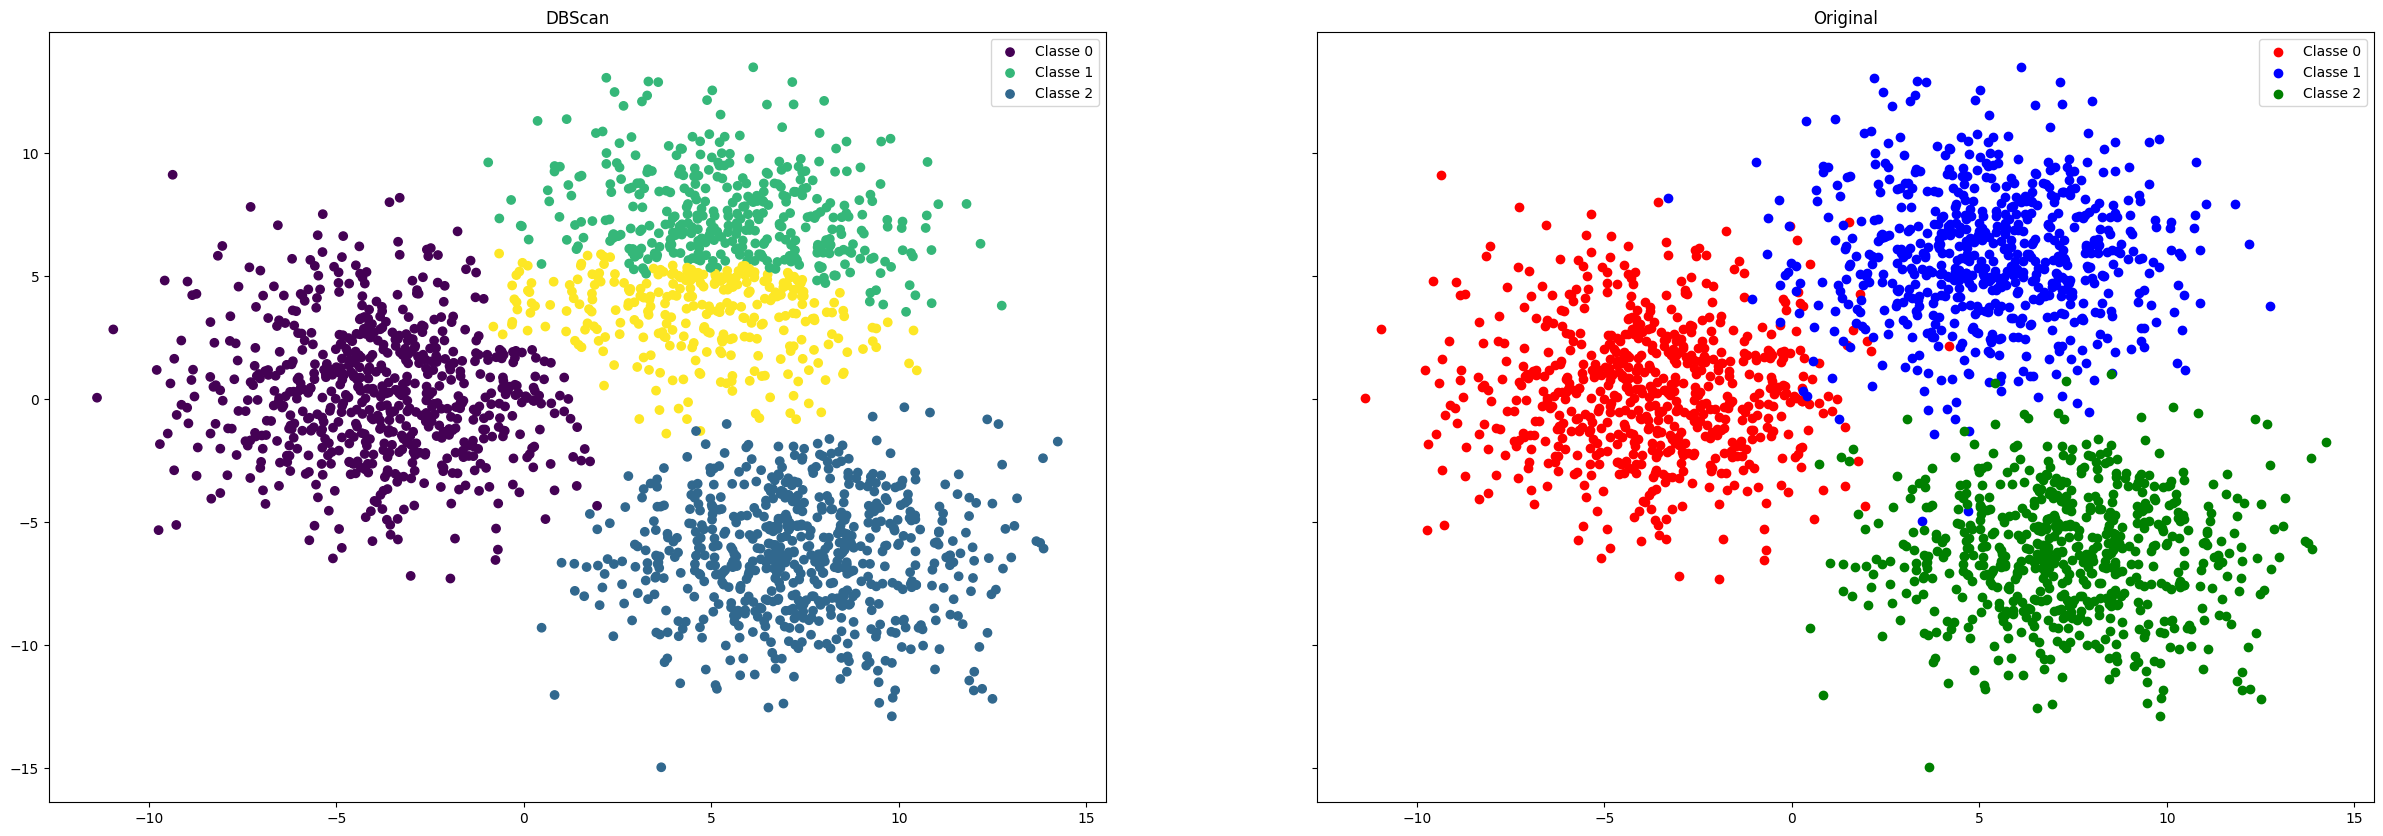

In [22]:
f,(ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(30,10),label='Classe')
ax1.set_title("DBScan")
for label, color in label_colors.items():
    subset = dataframe_data[dataframe_data['label'] == label]
    ax1.scatter(subset['x'], subset['y'], c=X[dataframe_data['label'] == label], label=f'Classe {label}')
ax1.legend()
ax2.set_title("Original")
for label, color in label_colors.items():
    subset = dataframe_data[dataframe_data['label'] == label]
    ax2.scatter(subset['x'], subset['y'], c=color, label=f'Classe {label}')

# Add labels and legend
ax2.legend()